### Load data

In [1]:
import common
import pandas as pd
data_df, lects_df = common.load_lexirumah()
display(data_df.head())
display(lects_df.head())




Loading data...
Loaded data.


,ID,Lect_ID,Concept_ID,Form_according_to_Source,Form,Local_Orthography,Segments,Comment,Source
0,abui1241-fuime-sky-1,abui1241-fuime,sky,adi,adi,adi,"[a, d, i]",None,[schapper10]
1,abui1241-fuime-sun-1,abui1241-fuime,sun,wari,wari,wari,"[w, a, r, i]",None,[schapper10]
2,abui1241-fuime-moon-1,abui1241-fuime,moon,ije,ije,iye,"[i, j, e]",None,[schapper10]
3,abui1241-fuime-star-1,abui1241-fuime,star,fɪri,fɪri,firi,"[f, ɪ, r, i]",None,[schapper10]
4,abui1241-fuime-night-1,abui1241-fuime,night,tuŋtama,tuŋtama,tungtama,"[t, u, ŋ, t, a, m, a]",None,[schapper10]


,ID,Name,Family,Latitude,Longitude,Region,Glottocode,Iso,Culture,Description,Orthography,Comment,Macroarea
0,abui1241-fuime,"Abui, Fuimelang",Timor-Alor-Pantar,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
1,abui1241-petle,"Abui, Petleng",Timor-Alor-Pantar,-8.2144,124.593,"Kecamatan Teluk Mutiara, Kabupaten Alor, East ...",abui1241,abz,None,None,"[p/general, p/abui1241-petle]",None,Papunesia
2,abui1241-takal,"Abui, Takalelang",Timor-Alor-Pantar,-8.1887,124.6264,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,abui,None,"[p/general, p/abui1241-takal]",None,Papunesia
3,abui1241-ulaga,"Abui, Ulaga",Timor-Alor-Pantar,-8.403792,124.623702,"Kecamatan Alor Barat Daya, Kabupaten Alor, Eas...",abui1241,abz,None,None,"[p/general, p/abui1241-ulaga]",None,Papunesia
4,adan1251-lawah,"Adang, Lawahing",Timor-Alor-Pantar,-8.2109,124.4272,"Kecamatan Alor Barat Laut, Kabupaten Alor, Eas...",adan1251,adn,None,None,"[p/general, p/adan1251-lawah]",None,Papunesia


### Select and combine data

In [2]:
#lects_df = lects_df[["ID", "Name", "Family", "Region", "Latitude", "Longitude"]]
# Filter out proto-languages
lects_df = lects_df[~lects_df["Name"].str.startswith("proto-")]
lects_alorese = lects_df[lects_df["Name"].str.startswith("Alorese")]
# Four Western Lamaholot languages close to Alorese
#lects_lamaholot_related = lects_df[lects_df["Name"].str.contains(
#    "Lamalera|Lewotobi|Lewoingu|Lewolema", case=False, regex=True)]
lects_western_lamaholot = lects_df[lects_df["Iso"].isin(["adr", "lmr", "slp", "ila", "lwt"])]
# Flores-Lembata family, but with preceding WL varieties excluded (and Alorese excluded)
lects_flores_lembata = lects_df[(lects_df["ID"].str.startswith("lama") | lects_df["ID"].str.startswith("sika") | lects_df["ID"].str.startswith("keda")) & ~lects_df.index.isin(lects_western_lamaholot.index)]
# Timor-Alor-Pantar languages, but only Alor-Pantar languages, spoken adjacent to Alorese
lects_alor_pantar = lects_df[lects_df["Family"].str.startswith("Timor-Alor-Pantar") & lects_df["Region"].str.contains("Alor|Pantar", case=False, regex=True)]
# Other Timor-Alor-Pantor languages, spoken on Timor (and small island Kisar)
lects_timor = lects_df[lects_df["Family"].str.startswith("Timor-Alor-Pantar") & ~lects_df.index.isin(lects_alor_pantar.index)]
lects_selected_df = pd.concat([lects_alorese, lects_western_lamaholot, lects_flores_lembata, lects_alor_pantar, lects_timor])

# Join data with lect name from lects table
# This order (first select lects, then merge) fastest
data_langs_df = data_df[data_df["Lect_ID"].isin(lects_selected_df["ID"])]
data_langs_df = data_langs_df.rename(columns={"ID":"Form_ID"})
data_merged_df = data_langs_df.merge(lects_df, how="left", left_on="Lect_ID", right_on="ID")
data_merged_df = data_merged_df.drop("ID", axis=1)
display(data_merged_df.head())


,Form_ID,Lect_ID,Concept_ID,Form_according_to_Source,Form,Local_Orthography,Segments,Comment_x,Source,Name,...,Latitude,Longitude,Region,Glottocode,Iso,Culture,Description,Orthography,Comment_y,Macroarea
0,abui1241-fuime-sky-1,abui1241-fuime,sky,adi,adi,adi,"[a, d, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
1,abui1241-fuime-sun-1,abui1241-fuime,sun,wari,wari,wari,"[w, a, r, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
2,abui1241-fuime-moon-1,abui1241-fuime,moon,ije,ije,iye,"[i, j, e]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
3,abui1241-fuime-star-1,abui1241-fuime,star,fɪri,fɪri,firi,"[f, ɪ, r, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
4,abui1241-fuime-night-1,abui1241-fuime,night,tuŋtama,tuŋtama,tungtama,"[t, u, ŋ, t, a, m, a]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia


### Compute phoneme distributions & compute feature matrix per language

In [3]:
#display(data_merged_df[data_merged_df["Lect_ID"]=="alor1247-baran"])

data_grouped_lang = data_merged_df.groupby("Lect_ID")
data_agg = data_grouped_lang.aggregate({"Segments":list, "Name": "first", "Family": "first", "Latitude": "first", "Longitude":"first"})
data_agg["phone_prob"] = data_agg["Segments"].apply(common.phone_prob)
data_agg["biphone_prob"] = data_agg["Segments"].apply(common.biphone_prob)
data_agg["phone_prob_existence"] = data_agg["Segments"].apply(common.phone_prob_existence)
data_agg["biphone_prob_existence"] = data_agg["Segments"].apply(common.biphone_prob_existence)
display(data_agg)

phone_prob_matrix = common.shared_feature_matrix(data_agg, "phone_prob")
biphone_prob_matrix = common.shared_feature_matrix(data_agg, "biphone_prob")
phone_prob_existence_matrix = common.shared_feature_matrix(data_agg, "phone_prob_existence")
biphone_prob_existence_matrix = common.shared_feature_matrix(data_agg, "biphone_prob_existence")

display(phone_prob_matrix)

,Segments,Name,Family,Latitude,Longitude,phone_prob,biphone_prob,phone_prob_existence,biphone_prob_existence
Lect_ID,,,,,,,,,
abui1241-fuime,"[[a, d, i], [w, a, r, i], [i, j, e], [f, ɪ, r,...","Abui, Fuimelang",Timor-Alor-Pantar,-8.236,124.6783,"{'a': 0.19303482587064677, 'd': 0.013930348258...","{('<', 'a'): 0.01651143099068586, ('a', 'd'): ...","{'a': 1, 'd': 1, 'i': 1, 'w': 1, 'r': 1, 'j': ...","{('<', 'a'): 1, ('a', 'd'): 1, ('d', 'i'): 1, ..."
abui1241-papun,"[[t, ɑ, m, ɑ, _, s, iː, l, ɑ, r], [ɑ, r, ʊ, ɪ,...",Papuna,Timor-Alor-Pantar,-8.334706,124.715864,"{'t': 0.05669050051072523, 'ɑ': 0.166496424923...","{('<', 't'): 0.02339688041594454, ('t', 'ɑ'): ...","{'t': 1, 'ɑ': 1, 'm': 1, '_': 1, 's': 1, 'iː':...","{('<', 't'): 1, ('t', 'ɑ'): 1, ('ɑ', 'm'): 1, ..."
abui1241-petle,"[[a, d, i], [a, k, u, n], [l, e, ŋ], [t, u, ŋ]...","Abui, Petleng",Timor-Alor-Pantar,-8.2144,124.593,"{'a': 0.19322709163346613, 'd': 0.007968127490...","{('<', 'a'): 0.021346469622331693, ('a', 'd'):...","{'a': 1, 'd': 1, 'i': 1, 'k': 1, 'u': 1, 'n': ...","{('<', 'a'): 1, ('a', 'd'): 1, ('d', 'i'): 1, ..."
abui1241-takal,"[[ä, d, i], [w, ä, r], [i, j, ä], [f, iː, r...","Abui, Takalelang",Timor-Alor-Pantar,-8.1887,124.6264,"{'ä': 0.194251497005988, 'd': 0.0148502994011...","{('<', 'ä'): 0.013119533527696793, ('ä', 'd'...","{'ä': 1, 'd': 1, 'i': 1, 'w': 1, 'r': 1, 'j':...","{('<', 'ä'): 1, ('ä', 'd'): 1, ('d', 'i'): 1..."
abui1241-ulaga,"[[a, d, i], [w, a, r, i], [i, j, a], [f, i, r,...","Abui, Ulaga",Timor-Alor-Pantar,-8.403792,124.623702,"{'a': 0.18317073170731707, 'd': 0.015121951219...","{('<', 'a'): 0.013990394654416372, ('a', 'd'):...","{'a': 1, 'd': 1, 'i': 1, 'w': 1, 'r': 1, 'j': ...","{('<', 'a'): 1, ('a', 'd'): 1, ('d', 'i'): 1, ..."
...,...,...,...,...,...,...,...,...,...
teiw1235-adiab,"[[b, u, l, a], [w, a, r], [w, u, r], [dʒ, i, f...","Teiwa, Adiabang",Timor-Alor-Pantar,-8.326,124.228,"{'b': 0.02823179791976226, 'u': 0.057454185240...","{('<', 'b'): 0.013130898645876077, ('b', 'u'):...","{'b': 1, 'u': 1, 'l': 1, 'a': 1, 'w': 1, 'r': ...","{('<', 'b'): 1, ('b', 'u'): 1, ('u', 'l'): 1, ..."
teiw1235-nule,"[[g, u, n, a, ʔ], [w, a, r], [w, u, r], [j, i,...","Teiwa, Nule",Timor-Alor-Pantar,-8.3775,124.2303,"{'g': 0.04088345864661654, 'u': 0.043703007518...","{('<', 'g'): 0.014156508061344868, ('g', 'u'):...","{'g': 1, 'u': 1, 'n': 1, 'a': 1, 'ʔ': 1, 'w': ...","{('<', 'g'): 1, ('g', 'u'): 1, ('u', 'n'): 1, ..."
tiay1238,"[[n, oː], [a, t, iː], [k, u, i], [k, a, g, i, ...",Tiyei,Timor-Alor-Pantar,-8.295197,124.756008,"{'n': 0.03647586980920314, 'oː': 0.01066217732...","{('<', 'n'): 0.00702576112412178, ('n', 'oː'):...","{'n': 1, 'oː': 1, 'a': 1, 't': 1, 'iː': 1, 'k'...","{('<', 'n'): 1, ('n', 'oː'): 1, ('oː', '>'): 1..."


,ʋ,i,f,õː,t̪,s,ʒ,p,ã,ãː,...,hː,ĩː,wː,dz,kː,ɓ,ɜː,kʰ,ɤː,mː
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,0.000000,0.108955,0.021891,0.0,0.0,0.014428,0.0,0.007960,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
abui1241-papun,0.000000,0.002043,0.000000,0.0,0.0,0.034219,0.0,0.009704,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
abui1241-petle,0.003984,0.105578,0.023904,0.0,0.0,0.013944,0.0,0.011952,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
abui1241-takal,0.007665,0.079760,0.016527,0.0,0.0,0.010299,0.0,0.013174,0.002395,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000240,0.0,0.0
abui1241-ulaga,0.000488,0.095854,0.015610,0.0,0.0,0.015854,0.0,0.013171,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000244,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
teiw1235-adiab,0.000000,0.062902,0.012878,0.0,0.0,0.033185,0.0,0.030708,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
teiw1235-nule,0.000000,0.063440,0.013628,0.0,0.0,0.027256,0.0,0.017387,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
tiay1238,0.000000,0.089787,0.011785,0.0,0.0,0.033109,0.0,0.022447,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Perform dimensionality reduction

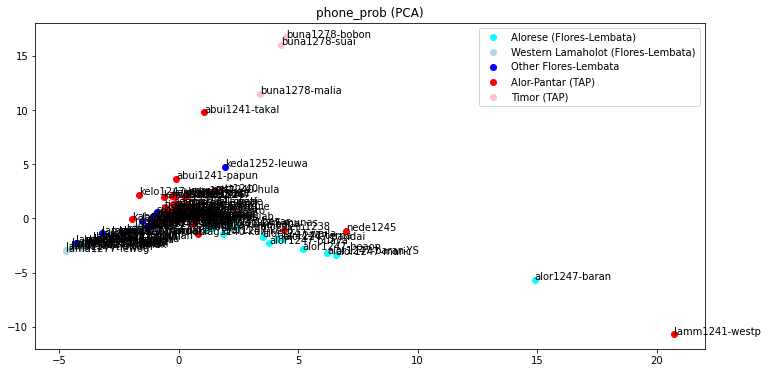

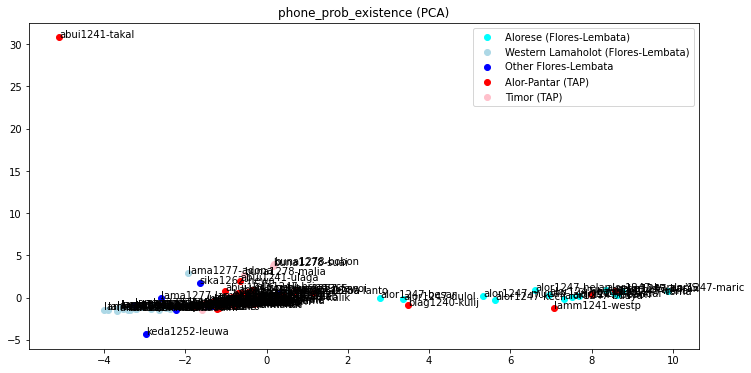

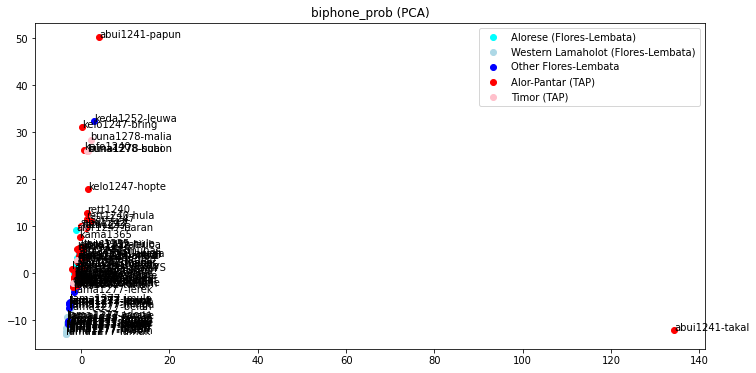

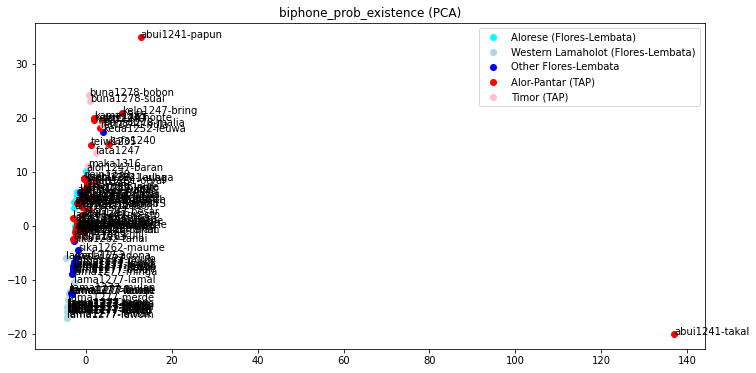

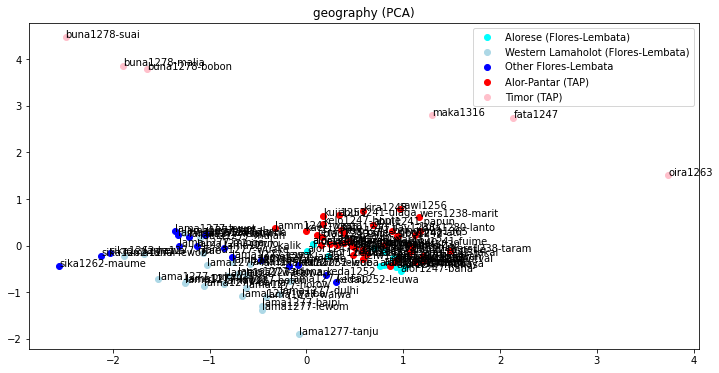

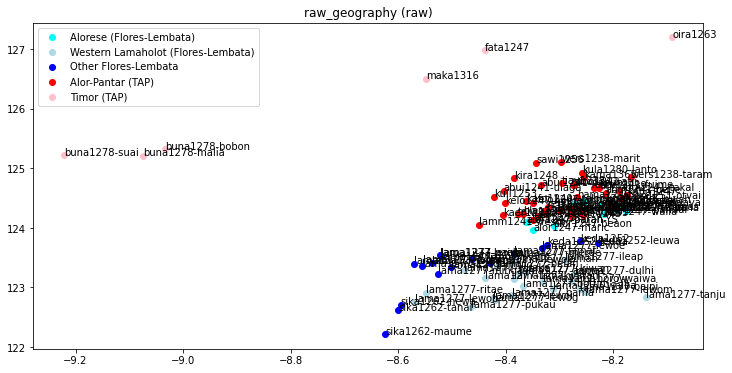

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS


# def create_colors_labels(lects):
#     def color_lect(lect):
#         if lect in list(lects_tap["ID"]):
#             return "red", "Timor-Alor-Pantar"
#         elif lect in list(lects_alorese["ID"]):
#             return "black", "Alorese"
#         elif lect in list(lects_lamaholot_related["ID"]):
#             return "cyan", "Lamaholot"
#         else:
#             raise ValueError("Unsupported lect")
#     return [color_lect(lect) for lect in lects]

PLOT_LABELS = True

#TODO: check outliers, smaller dots, bigger plots
# TODO: Biphone prob with transition probabilities
# TODO: Phone and biphone existence probabilities

# Define language groups for plots
language_groups = {"Alorese (Flores-Lembata)": {"color": "cyan", "lects": lects_alorese["ID"]},
                   "Western Lamaholot (Flores-Lembata)": {"color": "lightblue", "lects": lects_western_lamaholot["ID"]},
                   "Other Flores-Lembata": {"color": "blue", "lects": lects_flores_lembata["ID"]},
                   "Alor-Pantar (TAP)": {"color": "red", "lects": lects_alor_pantar["ID"]},
                   "Timor (TAP)": {"color": "pink", "lects": lects_timor["ID"]}
                  }

dim_reds_available = {"PCA": PCA(n_components=2)}#,"MDS": MDS()}

analyses = {"phone_prob": phone_prob_matrix,
            "phone_prob_existence": phone_prob_existence_matrix,
            "biphone_prob": biphone_prob_matrix,
            "biphone_prob_existence": biphone_prob_existence_matrix,
            "geography": data_agg[["Latitude", "Longitude"]].fillna(0),
            "raw_geography": ["Latitude", "Longitude"],
            }

for study_label, study_data in analyses.items():
    if study_label == "raw_geography":
        reduce = False
        plot_cols = study_data
        dim_reds = {"raw": plot_cols}
    else:
        reduce = True
        dim_reds = dim_reds_available
    for dr_label, dr in dim_reds.items():
        common.reduce_plot(study_label, study_data, dr_label, dr, data_agg, language_groups, PLOT_LABELS, reduce)
        
        